In [12]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
df = pd.read_parquet("../data/matches_feature_engineered.parquet")

In [14]:
df = df.dropna()

In [15]:
df.info()
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 2075 entries, 11 to 2143
Data columns (total 48 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   round                               2075 non-null   object        
 1   match_date                          2075 non-null   datetime64[ns]
 2   home_team                           2075 non-null   object        
 3   guest_team                          2075 non-null   object        
 4   stadium                             2075 non-null   object        
 5   date_added                          2075 non-null   datetime64[ns]
 6   score_home_team                     2075 non-null   Int64         
 7   score_guest_team                    2075 non-null   Int64         
 8   winning_team                        2075 non-null   string        
 9   home_team_wins_last_5               2075 non-null   int64         
 10  home_team_draws_last_5      

In [16]:
import numpy as np

# Configuration
N_PREV_MATCHES = 10  # Number of historical matches to include
BASE_FEATURES = ["score_home_team", "score_guest_team", "is_home"]

# Additional features to include for each historical match
MATCH_FEATURES = [
    "wins_last_5",
    "draws_last_5",
    "loses_last_5",
    "goals_scored_last_5",
    "goals_conceded_last_5",
    "goal_difference_last_5",
]

# Current season stats features (will be added to each historical match)
SEASON_FEATURES = [
    "current_position",
    "goals_scored",
    "goals_conceded",
    "goal_difference",
    "wins_so_far",
    "draws_so_far",
    "losses_so_far",
    "wins_pct_so_far",
    "draws_pct_so_far",
    "losses_pct_so_far",
]

# Difference features (will be added to each sample)
DIFFERENCE_FEATURES = [
    "position_difference",
    "goal_scored_difference",
    "goal_conceded_difference",
    "wins_difference",
    "draws_difference",
    "losses_difference",
]


def get_team_matches(team, current_date, current_row, n_matches):
    """Get a team's last n matches with all requested features"""
    # Find team's recent matches
    team_matches = df[
        ((df["home_team"] == team) | (df["guest_team"] == team))
        & (df["match_date"] < current_date)
    ].sort_values("match_date", ascending=False)

    matches_data = []
    for _, row in team_matches.head(n_matches).iterrows():
        # Determine if team was home or away in this historical match
        is_home = 1 if row["home_team"] == team else 0
        prefix = "home_team_" if is_home else "guest_team_"

        # Base match features
        features = [
            row["score_home_team"] if is_home else row["score_guest_team"],
            row["score_guest_team"] if is_home else row["score_home_team"],
            is_home,
        ]

        # Add match-specific features
        features.extend([row[f"{prefix}{feat}"] for feat in MATCH_FEATURES])

        # Add current season stats (from the current match's perspective)
        current_prefix = (
            "home_team_" if team == current_row["home_team"] else "guest_team_"
        )
        features.extend(
            [current_row[f"{current_prefix}{feat}"] for feat in SEASON_FEATURES]
        )

        matches_data.append(features)

    # Pad with zeros if not enough matches
    if matches_data:
        num_features = len(matches_data[0])
    else:
        num_features = len(BASE_FEATURES) + len(MATCH_FEATURES) + len(SEASON_FEATURES)

    while len(matches_data) < n_matches:
        matches_data.append([0] * num_features)

    return matches_data


def add_difference_features(home_data, away_data, current_row):
    """Add difference features between teams"""
    diff_features = [
        current_row["home_team_position_difference"],
        current_row["home_team_goal_scored_difference"],
        current_row["home_team_goal_conceded_difference"],
        current_row["wins_difference"],
        current_row["draws_difference"],
        current_row["losses_difference"],
    ]

    # Add to each historical match pair
    for i in range(len(home_data)):
        home_data[i].extend(diff_features)
        away_data[i].extend(diff_features)

    return home_data, away_data


# Prepare dataset
X = []
for idx, row in df.iterrows():
    # Get home team's last N matches
    home_matches = get_team_matches(
        row["home_team"], row["match_date"], row, N_PREV_MATCHES
    )

    # Get away team's last N matches
    away_matches = get_team_matches(
        row["guest_team"], row["match_date"], row, N_PREV_MATCHES
    )

    # Add difference features
    home_matches, away_matches = add_difference_features(
        home_matches, away_matches, row
    )

    # Combine (home matches first, then away matches)
    combined = home_matches + away_matches
    X.append(combined)

X = np.array(X)
y = pd.get_dummies(df["winning_team"]).values

print("Final dataset shape:")
print(f"X: {X.shape}")  # (samples, N_PREV_MATCHES*2, total_features)
print(f"Number of features per match: {X.shape[2]}")
print(f"y: {y.shape}")

Final dataset shape:
X: (2075, 20, 25)
Number of features per match: 25
y: (2075, 3)


In [17]:
class MatchPredictor(nn.Module):
    def __init__(self, input_shape, hidden_size=48, num_layers=1, dropout=0.5):
        super().__init__()
        total_matches, n_features = input_shape
        self.n_prev_matches = total_matches // 2

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False,
            dropout=0,
        )

        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 1),
        )

        # Classifier
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.LeakyReLU(),
            nn.Linear(hidden_size // 2, 3),
        )

        # Proper weight initialization
        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if "weight" in name:
                if param.dim() > 1:  # Only initialize weights with dim > 1
                    if "lstm" in name:
                        nn.init.orthogonal_(param)
                    else:
                        nn.init.xavier_normal_(param)
                elif "bias" in name:
                    nn.init.constant_(param, 0.1)

    def forward(self, x):
        home_seq = x[:, : self.n_prev_matches, :]
        away_seq = x[:, self.n_prev_matches :, :]

        home_out, _ = self.lstm(home_seq)
        away_out, _ = self.lstm(away_seq)

        def _apply_attention(sequence):
            attn_weights = torch.softmax(self.attention(sequence), dim=1)
            return (sequence * attn_weights).sum(dim=1)

        home_embed = _apply_attention(home_out)
        away_embed = _apply_attention(away_out)

        combined = torch.cat([home_embed, away_embed], dim=1)
        return self.fc(combined)

In [18]:
# Convert 'winning_team' to class indices
df["outcome"] = df["winning_team"].map({"home": 0, "guest": 1, "draw": 2})
y = torch.tensor(df["outcome"].values, dtype=torch.long)  # Shape: (num_matches,)

In [31]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.utils import compute_class_weight


class TrainingMetrics:
    """Helper class to track and plot training metrics"""

    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []

    def update(self, train_loss, val_loss, train_acc, val_acc):
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.train_accs.append(train_acc)
        self.val_accs.append(val_acc)

    def plot_metrics(self):
        import matplotlib.pyplot as plt

        plt.figure(figsize=(12, 5))

        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label="Train Loss")
        plt.plot(self.val_losses, label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.legend()

        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(self.train_accs, label="Train Accuracy")
        plt.plot(self.val_accs, label="Validation Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Training and Validation Accuracy")
        plt.legend()

        plt.tight_layout()
        plt.show()


def train_model(X, y, epochs=20, batch_size=32, learning_rate=0.001):
    """Enhanced training function with label validation"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    metrics = TrainingMetrics()

    # Convert labels to numpy and validate
    y_np = np.array(y)
    unique_labels = np.unique(y_np)
    valid_labels = {0, 1, 2}

    # Check for invalid labels
    invalid_labels = set(unique_labels) - valid_labels
    if invalid_labels:
        raise ValueError(
            f"Invalid labels found in y: {invalid_labels}. Only 0, 1, 2 are allowed."
        )

    # Data preparation
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.LongTensor(y_np)
    dataset = TensorDataset(X_tensor, y_tensor)

    # Train/validation split
    train_size = int(0.8 * len(dataset))
    train_dataset, val_dataset = random_split(
        dataset, [train_size, len(dataset) - train_size]
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Model setup - use present_classes instead of fixed [0,1,2]
    model = MatchPredictor(input_shape=(X.shape[1], X.shape[2])).to(device)
    class_weights = torch.FloatTensor(
        compute_class_weight("balanced", classes=np.array([0, 1, 2]), y=y_np)
    ).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(
        model.parameters(), lr=0.0005, weight_decay=0.001
    )  # Added L2 regularization
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=5, factor=0.5
    )

    # Training loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

        # Validation phase
        val_loss, val_correct, val_total = 0, 0, 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        # Calculate metrics
        avg_train_loss = train_loss / train_total
        avg_val_loss = val_loss / val_total
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total

        scheduler.step(avg_val_loss)

        metrics.update(avg_train_loss, avg_val_loss, train_acc, val_acc)

        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
            f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}"
        )

    metrics.plot_metrics()
    return model

In [32]:
import numpy as np
import torch
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


def evaluate_model(model, X_test, y_test, batch_size=32):
    """Comprehensive model evaluation with metrics"""
    device = next(model.parameters()).device

    # Prepare test data
    test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test))
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Get predictions
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate reports
    print("\nClassification Report:")
    print(
        classification_report(
            all_labels,
            all_preds,
            target_names=["Home Win", "Away Win", "Draw"],
            digits=4,
        )
    )

    print("\nConfusion Matrix:")
    plot_confusion_matrix(all_labels, all_preds)


def plot_confusion_matrix(true_labels, predictions):
    """Visualize confusion matrix"""
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Home Win", "Away Win", "Draw"],
        yticklabels=["Home Win", "Away Win", "Draw"],
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

In [33]:
from sklearn.model_selection import train_test_split


def train_and_evaluate(X, y, test_size=0.2, epochs=20, batch_size=32, lr=0.001):
    """Complete training and evaluation workflow"""
    # Data splitting
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )

    # Training phase
    print("\n=== TRAINING PHASE ===")
    model = train_model(
        X_train_val, y_train_val, epochs=epochs, batch_size=batch_size, learning_rate=lr
    )

    # Evaluation phase
    print("\n=== EVALUATION PHASE ===")
    evaluate_model(model, X_test, y_test, batch_size=batch_size)

    return model

C:\Users\User\AppData\Local\Temp\ipykernel_12764\1505519905.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y = np.array(y)



=== TRAINING PHASE ===
Epoch 1/50 | Train Loss: 1.3722 | Val Loss: 1.1155 | Train Acc: 0.3193 | Val Acc: 0.3554
Epoch 2/50 | Train Loss: 1.2661 | Val Loss: 1.1465 | Train Acc: 0.3584 | Val Acc: 0.3283
Epoch 3/50 | Train Loss: 1.2018 | Val Loss: 1.1515 | Train Acc: 0.3622 | Val Acc: 0.3223
Epoch 4/50 | Train Loss: 1.1450 | Val Loss: 1.1441 | Train Acc: 0.3916 | Val Acc: 0.3584
Epoch 5/50 | Train Loss: 1.1347 | Val Loss: 1.1374 | Train Acc: 0.3848 | Val Acc: 0.3675
Epoch 6/50 | Train Loss: 1.1238 | Val Loss: 1.1328 | Train Acc: 0.3916 | Val Acc: 0.3494
Epoch 7/50 | Train Loss: 1.1112 | Val Loss: 1.1270 | Train Acc: 0.4074 | Val Acc: 0.3404
Epoch 8/50 | Train Loss: 1.1087 | Val Loss: 1.1299 | Train Acc: 0.4202 | Val Acc: 0.3524
Epoch 9/50 | Train Loss: 1.1198 | Val Loss: 1.1349 | Train Acc: 0.3863 | Val Acc: 0.3464
Epoch 10/50 | Train Loss: 1.0837 | Val Loss: 1.1319 | Train Acc: 0.4142 | Val Acc: 0.3524
Epoch 11/50 | Train Loss: 1.0901 | Val Loss: 1.1277 | Train Acc: 0.4187 | Val Acc: 0.

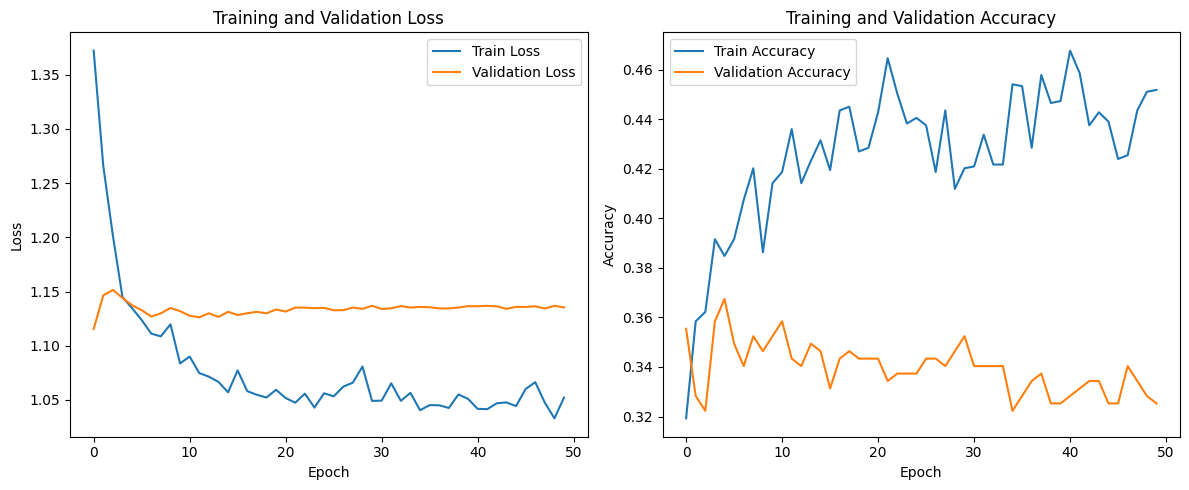


=== EVALUATION PHASE ===

Classification Report:
              precision    recall  f1-score   support

    Home Win     0.6515    0.2228    0.3320       193
    Away Win     0.3146    0.2617    0.2857       107
        Draw     0.2923    0.6609    0.4053       115

    accuracy                         0.3542       415
   macro avg     0.4195    0.3818    0.3410       415
weighted avg     0.4651    0.3542    0.3404       415


Confusion Matrix:


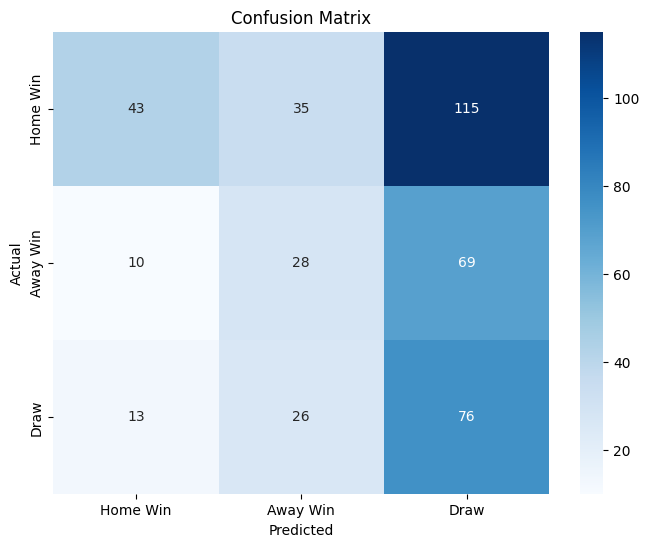

In [34]:
def preprocess_labels(y):
    """Ensure labels only contain 0, 1, 2"""
    y = np.array(y)
    unique = np.unique(y)

    if len(unique) > 3:
        raise ValueError("More than 3 unique labels found. Expected only 0, 1, 2.")

    # If you need to remap labels (e.g., if they're 1,2,3 instead of 0,1,2)
    if set(unique) == {1, 2, 3}:
        y = y - 1  # Convert 1,2,3 to 0,1,2
    elif not set(unique).issubset({0, 1, 2}):
        raise ValueError(
            f"Invalid labels found: {set(unique)}. Must be subset of 0,1,2"
        )

    return y


# Usage:
y_clean = preprocess_labels(y)
model = train_and_evaluate(X, y_clean, epochs=50, batch_size=64, lr=0.0005)

In [35]:
def predict_match_outcomes(model, df, home_team, away_team, match_date, n_matches=10):
    """
    Predicts match outcomes following the exact same feature engineering steps as training

    Args:
        model: Trained MatchPredictor model
        df: DataFrame containing historical matches
        home_team: Name of home team
        away_team: Name of away team
        match_date: Date of the match to predict
        n_matches: Number of historical matches to consider

    Returns:
        Dictionary with probabilities: {'home_win': float, 'away_win': float, 'draw': float}
    """
    # Convert match_date if needed
    if isinstance(match_date, str):
        match_date = pd.to_datetime(match_date)

    # Find the current match context (we'll create a dummy row)
    current_match = {
        "home_team": home_team,
        "guest_team": away_team,
        "match_date": match_date,
        # We need to add all difference features that would normally be in the row
        "home_team_position_difference": (
            df[df["home_team"] == home_team]["home_team_current_position"].iloc[-1]
            - df[df["guest_team"] == away_team]["guest_team_current_position"].iloc[-1]
        ),
        "home_team_goal_scored_difference": (
            df[df["home_team"] == home_team]["home_team_goals_scored"].iloc[-1]
            - df[df["guest_team"] == away_team]["guest_team_goals_scored"].iloc[-1]
        ),
        "home_team_goal_conceded_difference": (
            df[df["home_team"] == home_team]["home_team_goals_conceded"].iloc[-1]
            - df[df["guest_team"] == away_team]["guest_team_goals_conceded"].iloc[-1]
        ),
        "wins_difference": (
            df[df["home_team"] == home_team]["home_team_wins_so_far"].iloc[-1]
            - df[df["guest_team"] == away_team]["guest_team_wins_so_far"].iloc[-1]
        ),
        "draws_difference": (
            df[df["home_team"] == home_team]["home_team_draws_so_far"].iloc[-1]
            - df[df["guest_team"] == away_team]["guest_team_draws_so_far"].iloc[-1]
        ),
        "losses_difference": (
            df[df["home_team"] == home_team]["home_team_losses_so_far"].iloc[-1]
            - df[df["guest_team"] == away_team]["guest_team_losses_so_far"].iloc[-1]
        ),
        # Add all other current season stats for both teams
        **{
            f"home_team_{feat}": df[df["home_team"] == home_team][
                f"home_team_{feat}"
            ].iloc[-1]
            for feat in SEASON_FEATURES
        },
        **{
            f"guest_team_{feat}": df[df["guest_team"] == away_team][
                f"guest_team_{feat}"
            ].iloc[-1]
            for feat in SEASON_FEATURES
        },
    }

    # Get device from model
    device = next(model.parameters()).device

    # Get home team's last N matches (using same function as training)
    home_matches = get_team_matches(home_team, match_date, current_match, n_matches)

    # Get away team's last N matches
    away_matches = get_team_matches(away_team, match_date, current_match, n_matches)

    # Add difference features (same as training)
    home_matches, away_matches = add_difference_features(
        home_matches, away_matches, current_match
    )

    # Combine sequences (home first, then away)
    sample = home_matches + away_matches
    sample_tensor = torch.FloatTensor([sample]).to(device)  # Add batch dimension

    # Predict
    model.eval()
    with torch.no_grad():
        logits = model(sample_tensor)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]

    return {
        "home_win": float(probs[0]),
        "away_win": float(probs[1]),
        "draw": float(probs[2]),
    }

In [36]:
# Example usage remains identical:
pred = predict_match_outcomes(model, df, "Santos", "Flamengo", "16/07/2025")
print(
    f"Home: {pred['home_win']:.1%} | Draw: {pred['draw']:.1%} | Away: {pred['away_win']:.1%}"
)

Home: 28.3% | Draw: 26.3% | Away: 45.4%


C:\Users\User\AppData\Local\Temp\ipykernel_12764\1350328433.py:18: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  match_date = pd.to_datetime(match_date)
